<a href="https://colab.research.google.com/github/carloshernangarrido/vibration-control/blob/master/2dof_str_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [730]:
%reset -f

from typing import List, Union
import copy
import sympy as sm

# For simulation
import numpy as np # provides basic array types and some linear algebra
import matplotlib.pyplot as plt # used for plots

# For transfer function and state space representations
import scipy as sp
import scipy.signal as sg
eps = 1e-6

# System definition

## Structural Equation Of Motion

In [731]:
# mass, stiffness and damping
m1, c1, k1, m2, c12, k12, t = sm.symbols('m1, c1, k1, m2, c12, k12, t')
# inertance
b1, b12 = sm.symbols('b1, b12')

# mass, stiffness and damping matrices
M_s = sm.Matrix([[m1 + b1 + b12, -b12],
                 [-b12,           m2 + b12]])

K_s = sm.Matrix([[k1 + k12, -k12],
                 [-k12,      k12]])

C_s = sm.Matrix([[c1 + c12, -c12],
                 [-c12,      c12]])

# Seismic excitation matrix
B_s = sm.Matrix([[m1],
                 [m2]])

## State space representation

In [732]:
# State space
# System matrix
A = sm.Matrix([[sm.zeros(2,2), sm.eye(2)], 
               [-M_s.inv()*K_s,    -M_s.inv()*C_s]])
# Seismic Input Matrix
B = sm.Matrix([[sm.zeros(2,1)],
               [-M_s.inv()*B_s]])
# Story drift Output Matrix
C = sm.Matrix([[1,  0, 0, 0],
               [-1, 1, 0, 0]])
# Direct Transfer Matrix
D = sm.Matrix([[0],
               [0]])

In [733]:
sm.simplify(A)

Matrix([
[                                                                           0,                                                         0,                                                                            1,                                                         0],
[                                                                           0,                                                         0,                                                                            0,                                                         1],
[(b12*k12 - (b12 + m2)*(k1 + k12))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),         k12*m2/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2), (b12*c12 - (b12 + m2)*(c1 + c12))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),         c12*m2/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)],
[       (b1*k12 - b12*k1 + k12*m1)/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2), -k12*(b1 + m1)/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),        (b1*c12 - b12*c1 +

In [734]:
sm.simplify(B)

Matrix([
[                                                                        0],
[                                                                        0],
[     -(b12*m2 + m1*(b12 + m2))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)],
[-(b12*m1 + m2*(b1 + b12 + m1))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)]])

In [735]:
sm.simplify(C)

Matrix([
[ 1, 0, 0, 0],
[-1, 1, 0, 0]])

In [736]:
sm.simplify(D)

Matrix([
[0],
[0]])

In [737]:
D.shape

(2, 1)

## Frequency domain

### Classes

In [738]:
class TF:
  def __init__(self, A, B, C, D, 
               w = np.linspace(0, 10, 10000)):
    self.w = w
    self.A = A
    self.B = B
    self.C = C
    self.D = D

  def subs(self, i_output=None, parameters=None):
    i_output = self.i_output if i_output is None else i_output
    parameters = self.parameters if parameters is None else parameters
    self.i_output = i_output
    self.parameters = parameters
    self.A_num = np.array(self.A.subs(parameters), dtype=float)
    self.B_num = np.array(self.B.subs(parameters), dtype=float)
    self.C_num = np.array(self.C.subs(parameters), dtype=float)
    self.D_num = np.array(self.D.subs(parameters), dtype=float)
    self._num, self.den = sg.ss2tf(self.A_num, self.B_num, 
                                  self.C_num[i_output], self.D_num[i_output])
    for i, coef in enumerate(self._num[0]):
      if abs(coef) > eps:
        break
    self.num = self._num[0, i:]              
    self._tf = sg.lti(self.num, self.den)
    self._freqresp_w, self._freqresp_H = self._tf.freqresp(w=self.w)
    return self
    
  def H_inf(self, i_output=None, parameters=None):
    i_output = self.i_output if i_output is None else i_output
    parameters = self.parameters if parameters is None else parameters
    self.subs(i_output, parameters)
    return np.linalg.norm(self._freqresp_H, ord=np.inf)

  def H_2(self, i_output=None, parameters=None):
    i_output = self.i_output if i_output is None else i_output
    parameters = self.parameters if parameters is None else parameters
    self.subs(i_output, parameters)
    return np.linalg.norm(self._freqresp_H, ord=2)

  def natural_w(self, parameters):
    parameters = self.parameters if parameters is None else parameters
    self.subs(0, parameters)
    return np.sort(np.abs(np.linalg.eigvals(self.A_num)))


## Base parameters

## Classes

In [739]:
class Parameters:
  def __init__(self, base_parameters):
    self.base_parameters = base_parameters
  
  def get_parameters(self, alpha, b12_add, c12_add):
    parameters = self.base_parameters.copy()
    parameters['c1'] = alpha*parameters['k1']
    parameters['c12'] = alpha*parameters['k12']
    parameters['b12'] += b12_add
    parameters['c12'] += c12_add
    return parameters

## Values

In [740]:
## constans
# stiffness-proportional damping coefficient
alpha = 0.1

k1_c = 1
c1_c = alpha*k1_c
m1_c = 1
k12_c = 1
c12_c = alpha*k12_c
m2_c = 1
b1_c = 0
b12_c = 0

base_parameters = {'k1':  k1_c,
                   'c1':  c1_c,
                   'm1':  m1_c,
                   'k12': k12_c,
                   'c12': c12_c,
                   'm2':  m2_c,
                   'b1':  b1_c,
                   'b12': b12_c}

par = Parameters(base_parameters)

i_output = 0
tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha,0,0.1))
print(tf._tf)

TransferFunctionContinuous(
array([-1. , -0.4, -2. ]),
array([1.  , 0.5 , 3.02, 0.3 , 1.  ]),
dt: None
)


# Parametric analysis

## Functions

In [741]:
steps = 10
c12_add = np.linspace(0, 100*c1_c, steps)
b12_add = np.linspace(0, 10, steps)

alpha = .1
tf = TF(A, B, C, D)
H_1inf_b12_add = lambda x : tf.H_inf(0, 
                                     par.get_parameters(alpha=alpha, b12_add=x, c12_add=0))
H_1inf_c12_add = lambda x : tf.H_inf(0, 
                                     par.get_parameters(alpha=alpha, b12_add=0, c12_add=x))
H_12inf_b12_add = lambda x : tf.H_inf(1,
                                      par.get_parameters(alpha=alpha, b12_add=x, c12_add=0))
H_12inf_c12_add = lambda x : tf.H_inf(1, 
                                      par.get_parameters(alpha=alpha, b12_add=0, c12_add=x))

def damping_ratio(alpha, w):
  return alpha*w/2

natural_freqs = tf.natural_w(par.get_parameters(alpha=alpha, b12_add=0, c12_add=0))
print(f'natural frequencies = {natural_freqs} rad/s')
print(f'damping ratios = {[damping_ratio(alpha,w) for w in natural_freqs]}')

natural frequencies = [0.61803399 0.61803399 1.61803399 1.61803399] rad/s
damping ratios = [0.03090169943749473, 0.03090169943749473, 0.08090169943749477, 0.08090169943749477]


## Plots

Text(0.5, 0, '$b_{12add}$')

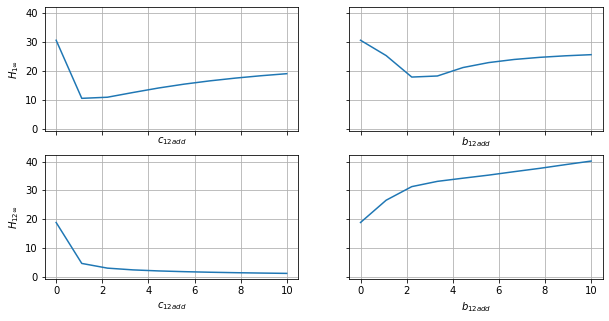

In [742]:
fig, ax = plt.subplots(2, 2, figsize=[10, 5], sharex=True, sharey=True)

[[elem.grid(which='both', axis='both') for elem in row] for row in ax]

ax[0,0].plot(c12_add, np.vectorize(H_1inf_c12_add)(c12_add))
ax[0,0].set_xlabel('$c_{12add}$')
ax[0,0].set_ylabel('$H_{1\infty}$')
ax[0,1].plot(b12_add, np.vectorize(H_1inf_b12_add)(b12_add))
ax[0,1].set_xlabel('$b_{12add}$')

ax[1,0].plot(c12_add, np.vectorize(H_12inf_c12_add)(c12_add))
ax[1,0].set_xlabel('$c_{12add}$')
ax[1,0].set_ylabel('$H_{12\infty}$')
ax[1,1].plot(b12_add, np.vectorize(H_12inf_b12_add)(b12_add))
ax[1,1].set_xlabel('$b_{12add}$')


# Multi objective optimization

## Functions

In [743]:
def optim_H_1_H_12_inf(tf, alpha, lambda_opt=1, n_iter_over2=3):
  assert 0 <= lambda_opt <= 1
  H_1_H_12_inf_c12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=0, c12_add=x)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=0, c12_add=x))
  H_1_H_12_inf_b12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=x, c12_add=0)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=x, c12_add=0))
  tfs = [copy.deepcopy(tf)]
  for i_iter in range(n_iter_over2):
    b12 = sp.optimize.minimize_scalar(H_1_H_12_inf_b12_add).x
    H_1_H_12_inf_c12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=b12, c12_add=x)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=b12, c12_add=x))
    tfs.append(copy.deepcopy(tf))
    c12 = sp.optimize.minimize_scalar(H_1_H_12_inf_c12_add).x
    H_1_H_12_inf_b12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=x, c12_add=c12)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=x, c12_add=c12))
    tfs.append(copy.deepcopy(tf))
  return tfs

## Single objective

In [744]:
tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha, 0, 0))
tfs = optim_H_1_H_12_inf(tf, alpha, lambda_opt=1)

### Plots

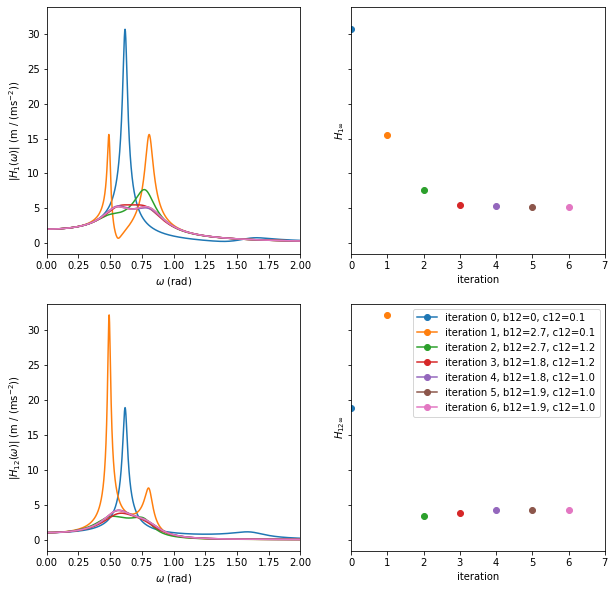

In [745]:
fig, ax = plt.subplots(2, 2, figsize=[10, 10], sharey=True)
for i, tf in enumerate(tfs):
  tf.subs(i_output=0)
  ax[0,0].plot(tf._freqresp_w, np.abs(tf._freqresp_H))
  ax[0,0].set_xlim([0, 2])
  ax[0,0].set_xlabel('$\omega$ (rad)')
  ax[0,0].set_ylabel('$|H_1(\omega)|$ (m / (ms$^{-2}$))')
  ax[0,1].plot(i, tf.H_inf(), marker='o')
  ax[0,1].set_ylabel('$H_{1\infty}$')
  ax[0,1].set_xlabel('iteration')
  ax[0,1].set_xlim([0, len(tfs)])
  tf.subs(i_output=1)
  ax[1,0].plot(tf._freqresp_w, np.abs(tf._freqresp_H), label=f"iteration {i}")
  ax[1,0].set_xlim([0, 2])
  ax[1,0].set_xlabel('$\omega$ (rad)')
  ax[1,0].set_ylabel('$|H_{12}(\omega)|$ (m / (ms$^{-2}$))')
  ax[1,1].plot(i, tf.H_inf(), marker='o', 
               label=f"iteration {i}, b12={round(tf.parameters['b12'],1)}, c12={round(tf.parameters['c12'],1)}")
  ax[1,1].set_ylabel('$H_{12 \infty}$')
  ax[1,1].set_xlabel('iteration')
  ax[1,1].set_xlim([0, len(tfs)])
  ax[1,1].legend()

plt.show()